# 2D ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FRingResonator.ipynb).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 2 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform the simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

Using Tidy3D credentials from stored file


## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# resolution
dl = 0.01

# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

In [3]:
# define pulse parameters
lambda0 = 0.5
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
grids_per_wavelength = lambda0 / dl
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#mediums)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#structures)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

Compute and visualize the waveguide modes.

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
)

mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, freq=freq0)
mode_data = mode_solver.solve(mode_spec=td.ModeSpec(num_modes=2))

mode_data_0, mode_data_1 = mode_data

[11:49:31] WARNING  No sources in simulation.                               ]8;id=650876;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:361

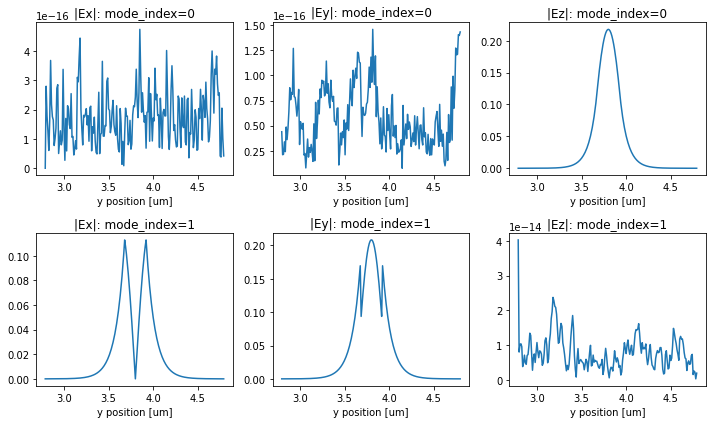

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data_0.field_data.Ex).plot(ax=ax1)
abs(mode_data_0.field_data.Ey).plot(ax=ax2)
abs(mode_data_0.field_data.Ez).plot(ax=ax3)
abs(mode_data_1.field_data.Ex).plot(ax=ax4)
abs(mode_data_1.field_data.Ey).plot(ax=ax5)
abs(mode_data_1.field_data.Ez).plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [8]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.4, 0.6, 1001)
freqs_measure = td.C_0 / lambdas_measure

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor.center = [+wg_insert_x, wg_center_y, 0]

Define simulation. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#simulation)
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction.

In [10]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 0.],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    pml_layers=[td.PML(), td.PML(), None])

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 0.],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    pml_layers=[td.PML(), td.PML(), None])

----
Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

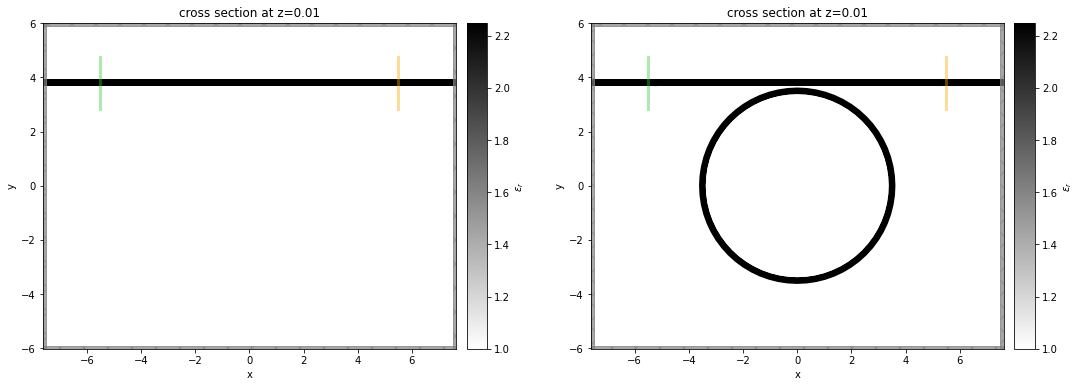

In [11]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [12]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

🏃  Working on 'with_ring'...

In [13]:
print(sim_data.log)

Simulation domain Nx, Ny, Nz: [1524, 1204, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.8349e+06.
Using subpixel averaging: True
Number of time steps: 2.8848e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 1.7332e-17
Compute source modes time (s):     0.4894
Compute monitor modes time (s):    3.1388

Rest of setup time (s):            1.4114

Starting solver...
- Time step    459 / time 7.96e-15s (  0 % done), field decay: 1.00e+00
- Time step  11539 / time 2.00e-13s (  4 % done), field decay: 4.12e-01
- Time step  23078 / time 4.00e-13s (  8 % done), field decay: 1.67e-01
- Time step  34617 / time 6.00e-13s ( 12 % done), field decay: 4.01e-02
- Time step  46156 / time 8.00e-13s ( 16 % done), field decay: 1.30e-02
- Time step  57695 / time 1.00e-12s ( 20 % done), field decay: 7.82e-03
- Time step  69234 / time 1.20e-12s ( 24 % done), field decay: 3.02e-03
- Time step  80773 / time 1.40e-12s ( 28 % done), field decay: 1.37e-03
- Time step  92312 / time 1

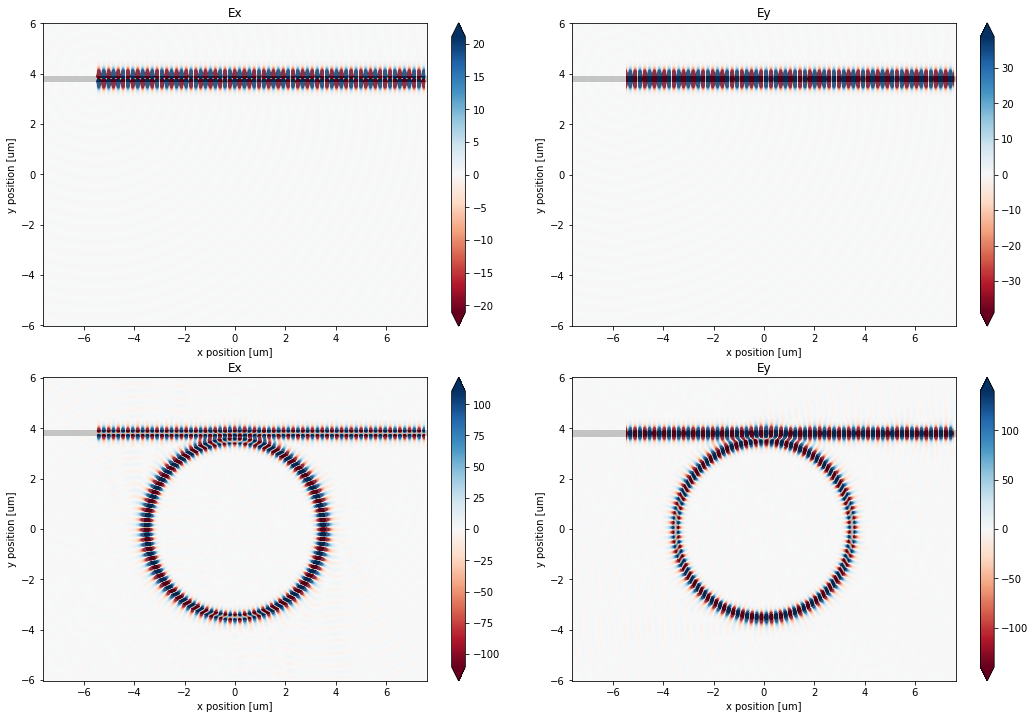

In [14]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))

ax1 = sim_data0.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax1)
ax2 = sim_data0.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

ax3 = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax3)
ax4 = sim_data.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax4)
ax3.set_title('Ex')
ax4.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [15]:
sim_data['mode']

ModeData(type='ModeData', data_dict={'amps': ModeAmpsData(type='ModeAmpsData', values=array([[[ 7.55723060e-10-3.59582745e-10j,
          3.57923721e-10-8.15643098e-11j,
          3.08960914e-10+6.09334237e-11j, ...,
          2.98689867e-10+1.03793277e-10j,
          3.09240338e-10+9.24653986e-11j,
          3.19688809e-10+7.98733544e-11j],
        [ 5.58413324e-01-8.18671053e-01j,
          4.07296731e-01-9.03354483e-01j,
          2.51759285e-01-9.56467075e-01j, ...,
         -8.78525938e-01-4.30269617e-01j,
         -9.24079756e-01-3.22392331e-01j,
         -9.55825626e-01-2.12086142e-01j]],

       [[-1.64568344e-12+8.21150003e-13j,
         -1.59783185e-12+1.08291827e-12j,
         -1.49911834e-12+1.43715107e-12j, ...,
          2.64895555e-14+9.38875395e-14j,
         -1.09661440e-14+7.89826037e-14j,
          1.06674512e-14+5.62263447e-14j],
        [-7.90095890e-05+4.90131122e-05j,
         -4.63923050e-05+5.58378459e-05j,
         -7.08591531e-07+1.57106968e-05j, ...,
          1.72032791e-05-5.98582382e-05j,
         -9.92528594e-06-3.97871028e-05j,
          2.67088676e-05-4.49915085e-05j]]]), data_attrs={'units': 'sqrt(W)', 'long_name': 'mode amplitudes'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]), direction=['+', '-']), 'n_complex': ModeIndexData(type='ModeIndexData', values=array([[1.3988473 +9.69950430e-18j, 1.39877819+4.17391072e-18j,
        1.39870909+4.87474072e-18j, ..., 1.33170173-2.34834482e-18j,
        1.33163771-1.73937595e-18j, 1.3315737 +3.44451455e-18j],
       [1.35411093-3.14694011e-18j, 1.35399612-9.26161522e-18j,
        1.35388129-2.72134161e-18j, ..., 1.24206216+1.04640935e-14j,
        1.24195919+1.05050952e-14j, 1.24185625+1.05281894e-14j]]), data_attrs={'units': 'None', 'long_name': 'complex effective index'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]))})

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [16]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

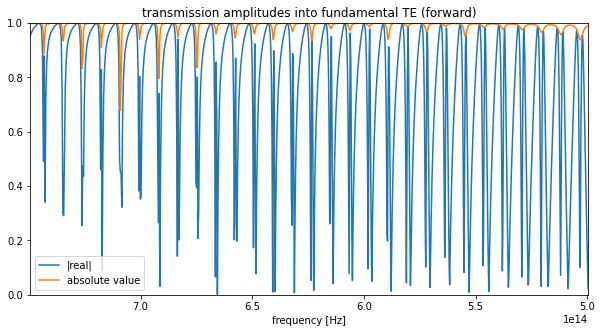

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
abs(transmission_amps.real).plot.line(x='f', ax=ax, label='|real|')
# abs(transmission_amps.imag).plot.line(x='f', ax=ax, label='|imag|')
abs(transmission_amps).plot.line(x='f', ax=ax, label='absolute value')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()